In [24]:
import wandb

wandb.init(
    project="mlp", 
    entity="jrbickelhaupt",
    config = {"learning_rate":0.001, "epochs": 100, "batch_size": 128, "dropout": 0.2}
)

In [25]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.1+cpu  Device: cpu


In [26]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [27]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


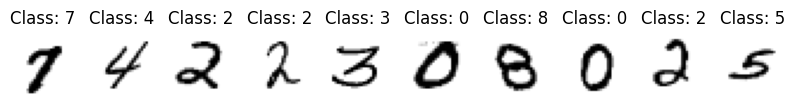

In [28]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [29]:
dropout = wandb.config['dropout']

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(dropout)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [30]:
wandb.watch(model)

def train(epoch, log_interval=200):
    # Set model to training mode
    
    wandb.log({"loss": lossv, "accuracy": accv})

    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            


In [31]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [35]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)
    wandb.log({"loss": lossv})


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.135269
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.256696
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.324688
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.083897
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.416701
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.094062
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.324428
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.347597
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.075273
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.095812

Validation set: Average loss: 0.1179, Accuracy: 9637/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.021724
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.231978
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.165084
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.260204
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.386323
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.148120
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.158283
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.229366
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.17

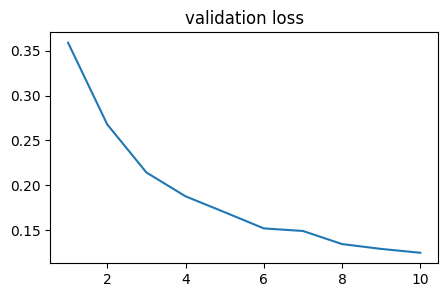

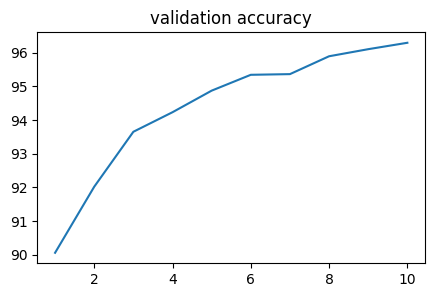

In [33]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the PyTorch documentation at http://pytorch.org/.